In [57]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import pairwise_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
%matplotlib inline

# Fazendo leitura da base de dados

In [70]:
df = pd.read_csv('water_potability_nonans.csv')
X = df.drop(columns=['Potability'])
y = df['Potability']

# Criando histogramas para cada atributo

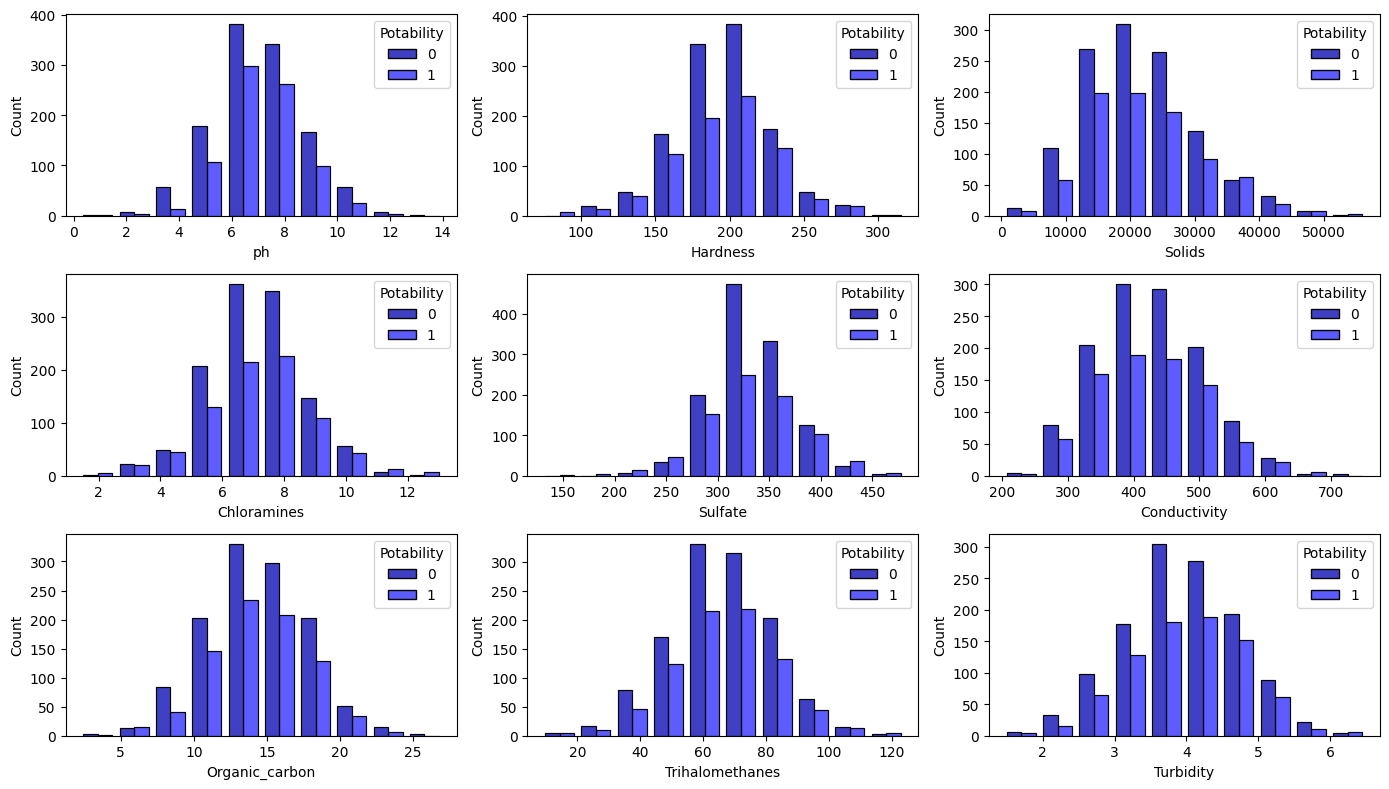

In [59]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(14,8))
sns.histplot(data=df, bins=10, x='ph', hue='Potability', multiple='dodge', shrink=0.8, ax=axes[0][0])
sns.histplot(data=df, bins=10, x='Hardness', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[0][1])
sns.histplot(data=df, bins=10, x='Solids', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[0][2])
sns.histplot(data=df, bins=10, x='Chloramines', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[1][0])
sns.histplot(data=df, bins=10, x='Sulfate', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[1][1])
sns.histplot(data=df, bins=10, x='Conductivity', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[1][2])
sns.histplot(data=df, bins=10, x='Organic_carbon', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[2][0])
sns.histplot(data=df, bins=10, x='Trihalomethanes', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[2][1])
sns.histplot(data=df, bins=10, x='Turbidity', hue='Potability', multiple='dodge', shrink=0.8,ax=axes[2][2])
fig.tight_layout()
plt.show()


### Neste caso está muito difícil saber diferenciar os atributos, pois estão muito parecidos. Devido a isso, para fazer o PCA vamos utilizar todos os atributos.

Importando biblioteca para usar o PCA

In [60]:
from sklearn.decomposition import PCA

In [61]:
pca = PCA(n_components=2)
pca.fit(X)

PCA(n_components=2)

In [62]:
X_pca = pca.transform(X)  # Projetar os 10 atributos nos 2 componentes principais
X_pca_df = pd.DataFrame(X_pca, columns=['PC 0', 'PC 1'])

# Note que a dimensionalidade dos dados projetados agora tem apenas 2 atributos!
print("Instâncias priginais: %s\nInstâncias projetadas nos componentes principais: %s" % (str(X.shape), str(X_pca_df.shape)))


Instâncias priginais: (2011, 9)
Instâncias projetadas nos componentes principais: (2011, 2)


#Plotar os dados projetados nos componentes principais. Colorir os pontos de acordo com o target (atributo de saída)

<Axes: xlabel='PC 0', ylabel='PC 1'>

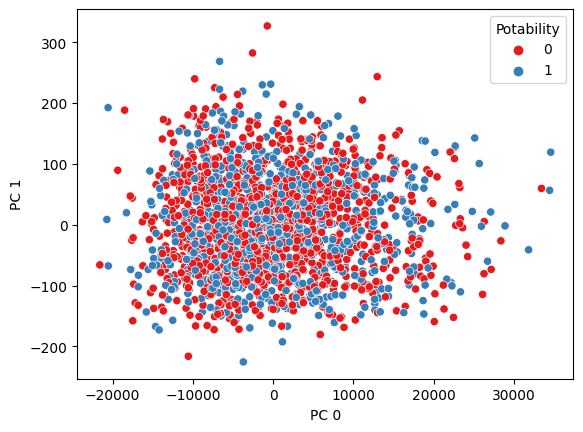

In [63]:
sns.set_palette('seismic')
sns.scatterplot(data=X_pca_df, x='PC 0', y='PC 1', hue=y, palette='Set1')

Agora vamos separar os dados para fazer os treinos e testes para o KNN


In [79]:
X_treino, X_teste, y_treino, y_teste = train_test_split(
        X.values, y.values, test_size=0.2, random_state=1,
        stratify=y.values)

In [82]:
from sklearn.model_selection import GridSearchCV #busca exaustiva para otimização de hiperparâmetro por validação cruzada

k1 = 10 #controla o número de vias da validação cruzada para estimar o desempenho do modelo
k2 = 5 #controla o número de vida da validação cruzada para otimização de hiperparametros

#usar o protocolo de validação cruzada estratificada
skf = StratifiedKFold(n_splits=k1, shuffle=True, random_state=1)

acuracias = []

#a função split retorna os índices das instâncias que devem ser usadas para o treinamento e o teste.
for idx_treino, idx_teste in skf.split(X, y):
    #extrair as instâncias de treinamento de acordo com os índices fornecidos pelo skf.split
    X_treino = X.iloc[idx_treino]
    y_treino = y.iloc[idx_treino]

    #extrair as instâncias de teste de acordo com os índices fornecidos pelo skf.split
    X_teste = X.iloc[idx_teste]
    y_teste = y.iloc[idx_teste]

    #colocar todas as variáveis na mesma escala, usando o conjunto de treinamento para calcular os parâmetros da escala
    ss = StandardScaler()
    ss.fit(X_treino)
    X_treino = ss.transform(X_treino)
    X_teste = ss.transform(X_teste)

    #combinações de parametros otimizar. Aqui estamos apenas otimizando o número de vizinhos mais próximos para o knn (k).
    #Entretanto, podemos colocar todos os valores de todos os parametros. O sklearn se encarrega de gerar todas as combinações.
    params = {'n_neighbors' : range(1,30,2)}
    #instanciar um KNN com parametros padrão
    knn = KNeighborsClassifier()
    #instanciar um GridSearchCV com k2 vias.
    knn = GridSearchCV(knn, params, cv=StratifiedKFold(n_splits=k2))
    #realizar a otimização dos hiperparâmetros e treinar o modelo final com a melhor combinação de hiperparametros com todos os dados de treinamento
    knn.fit(X_treino, y_treino)

    #calcular a acurácia no conjunto de testes desta iteração e salvar na lista.
    acuracias.append(accuracy_score(y_teste, knn.predict(X_teste)))

#calcular as estatísticas da validação cruzada. Estas estatísticas nos dão uma confiança que, na média, este é o desempenho esperado
#do classificador no mundo real.
print("min: %.2f, max: %.2f, avg +- std: %.2f+-%.2f" % (min(acuracias), max(acuracias), np.mean(acuracias), np.std(acuracias)))


min: 0.63, max: 0.67, avg +- std: 0.65+-0.01
